## Sleep exploratory analysis steps:
1. import prepared dataset
2. Create an ML model for predicting best conditions for high sleeping score
   * **Problem definition** - can I predict best conditions to achieve high sleeping score ?
   * **Data** - my own sleeping score data collected by garmin watch. Need to divide into train, valid and test datasets
   * **Evaluation** -what metrics to use to evaluate model
   * **Features** - 




In [1]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Import dataset

sleep = pd.read_csv("sleep_cleaned_df.csv", parse_dates = ["BedTime", "WakeTime", "CalendarDate"])
print(sleep.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   deepSleepSeconds      276 non-null    int64         
 1   lightSleepSeconds     276 non-null    int64         
 2   remSleepSeconds       276 non-null    float64       
 3   awakeSleepSeconds     276 non-null    int64         
 4   unmeasurableSeconds   276 non-null    int64         
 5   averageRespiration    276 non-null    float64       
 6   lowestRespiration     276 non-null    float64       
 7   highestRespiration    276 non-null    float64       
 8   awakeCount            276 non-null    int64         
 9   avgSleepStress        276 non-null    float64       
 10  restlessMomentCount   276 non-null    int64         
 11  overallScore          276 non-null    int64         
 12  qualityScore          276 non-null    int64         
 13  durationScore       

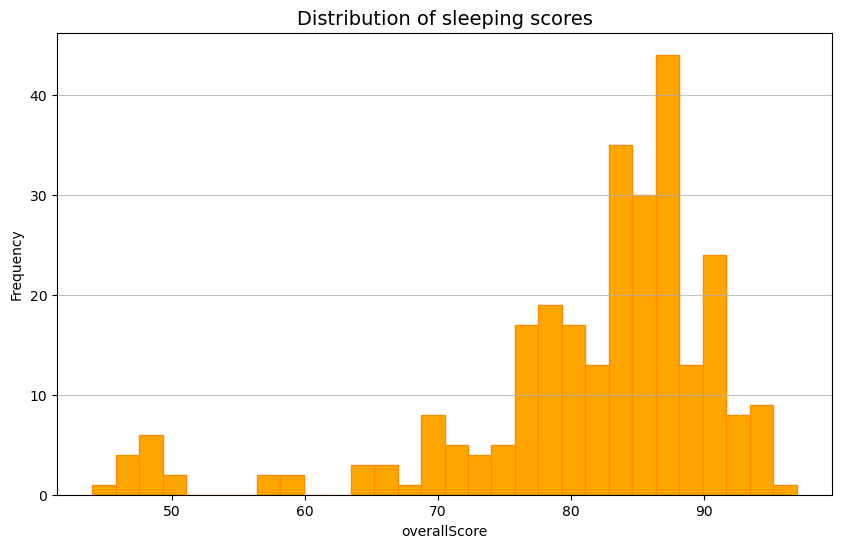

In [3]:
# Explore dataset
# what is the distribution of target variable? - left-skewed distribution
plt.figure(figsize=(10, 6))
plt.hist(sleep['overallScore'], bins=30, color='orange', edgecolor='darkorange')
plt.title('Distribution of sleeping scores', fontsize=14)
plt.xlabel('overallScore', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', alpha=0.75)

plt.show()

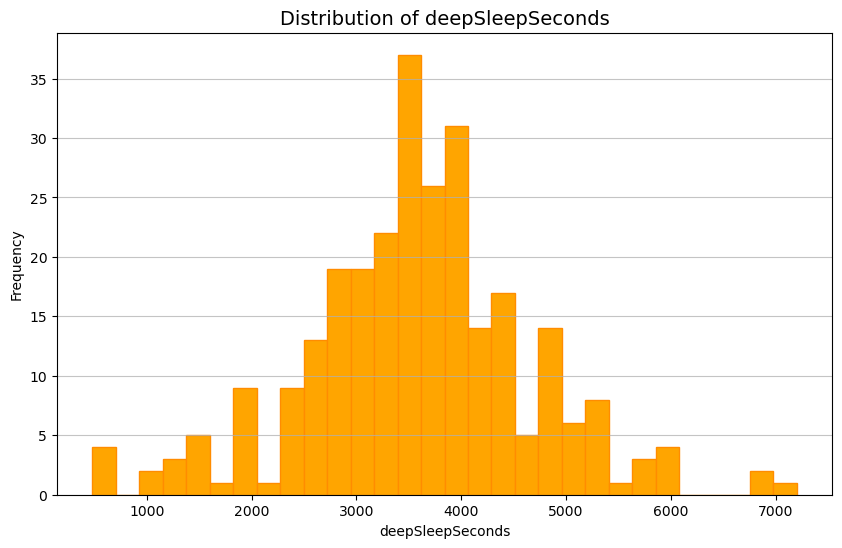

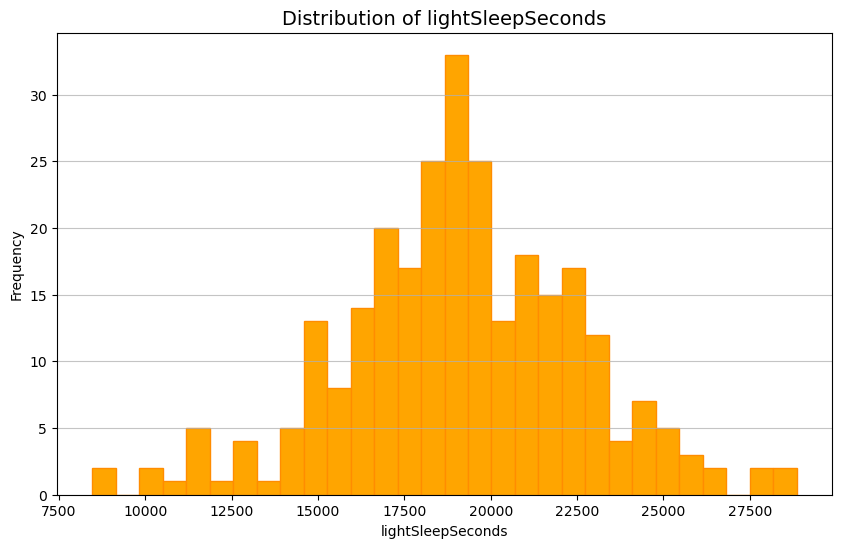

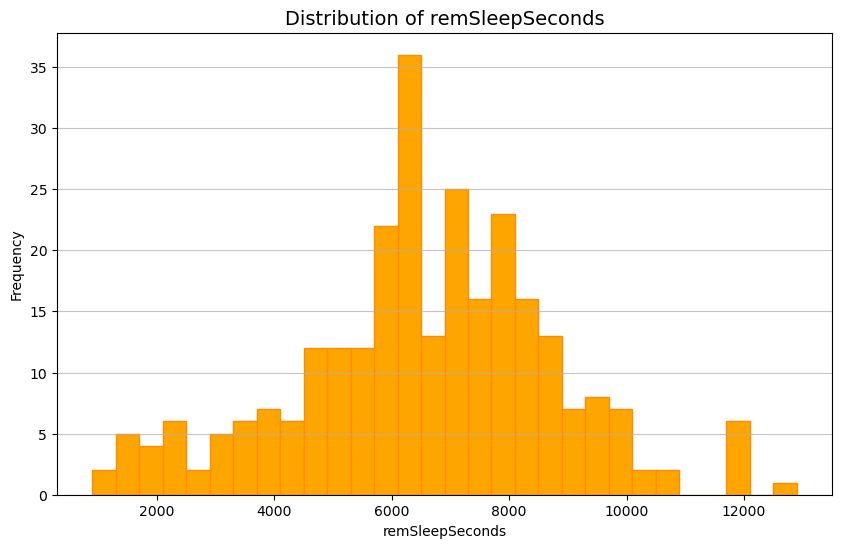

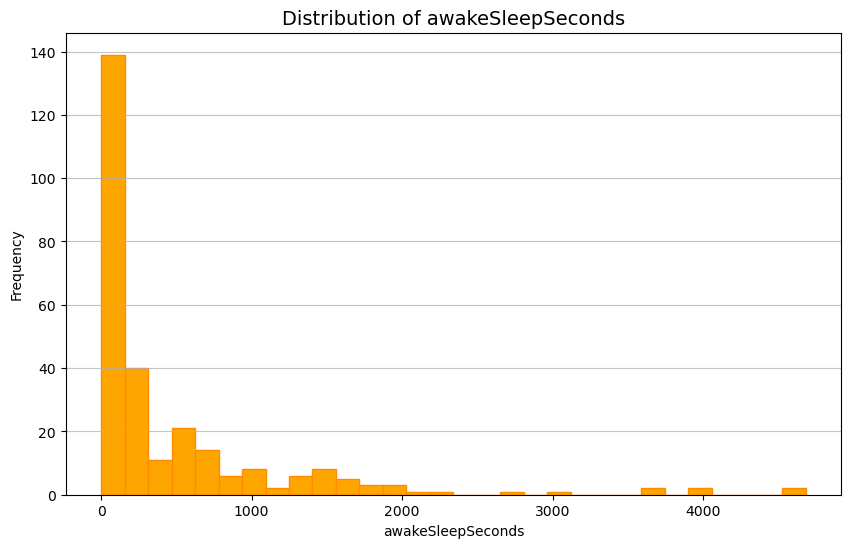

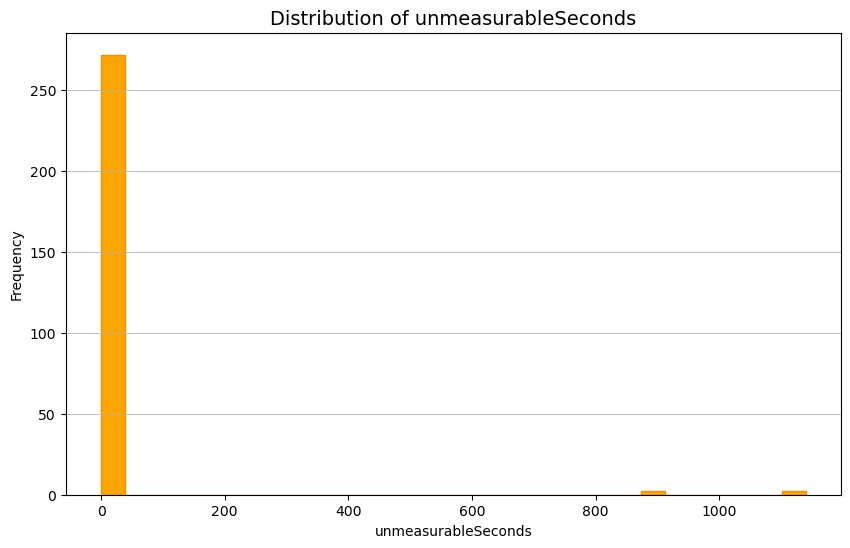

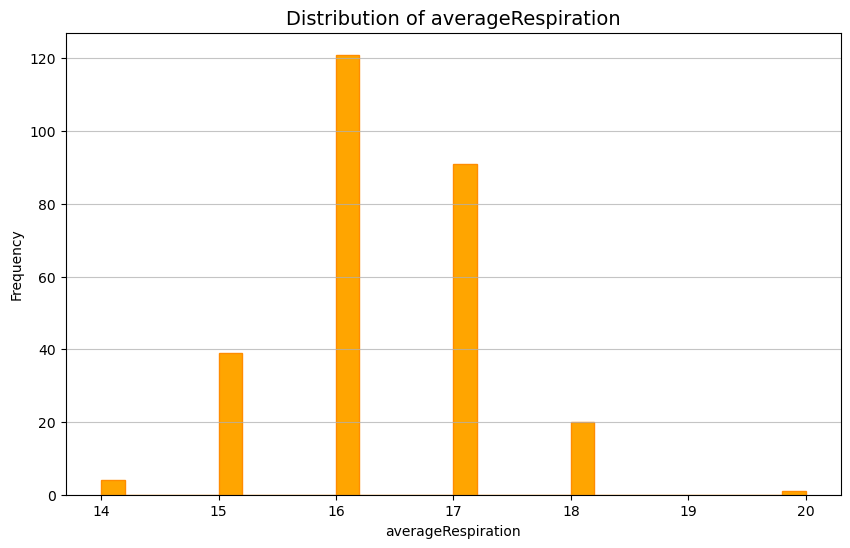

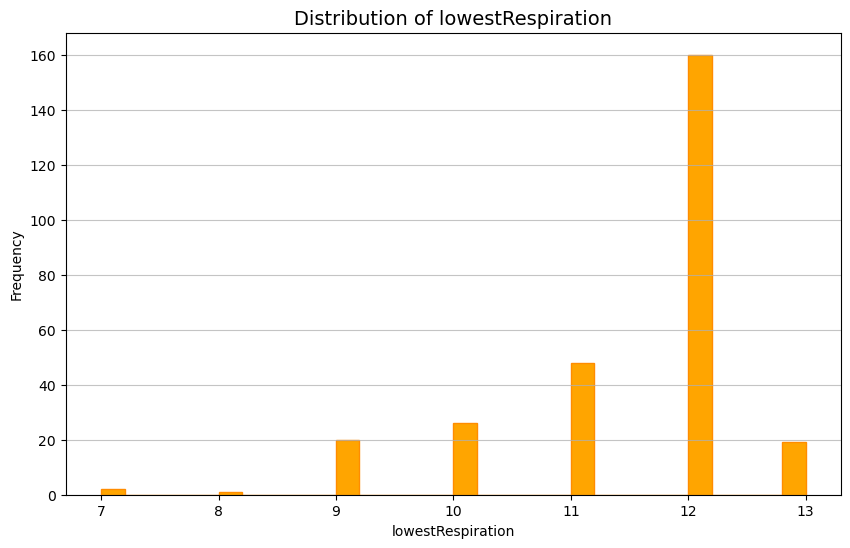

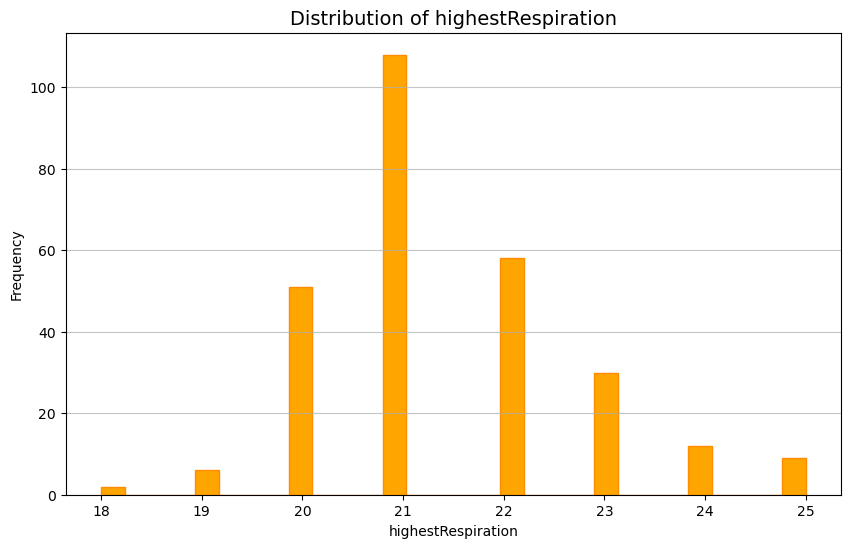

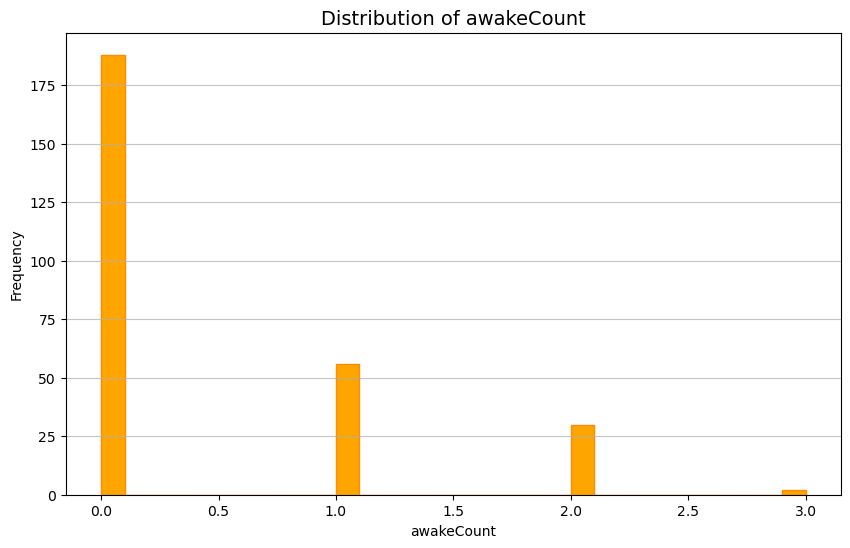

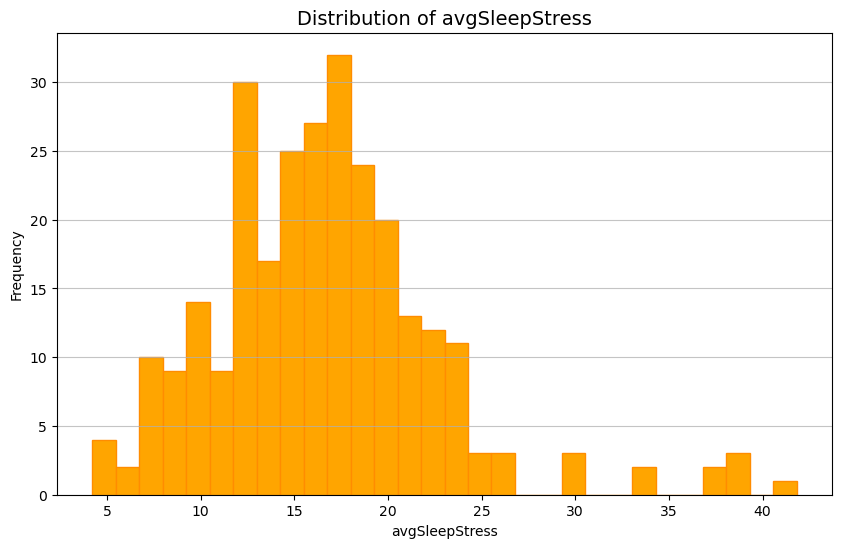

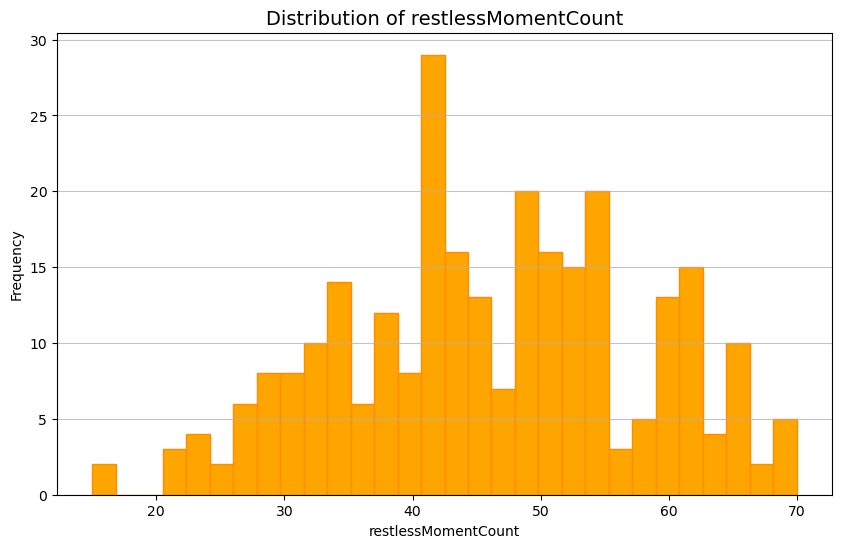

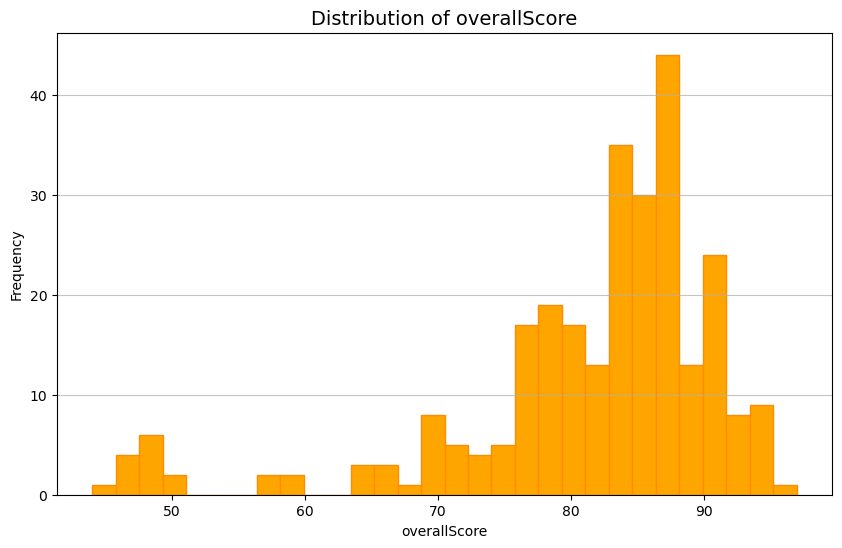

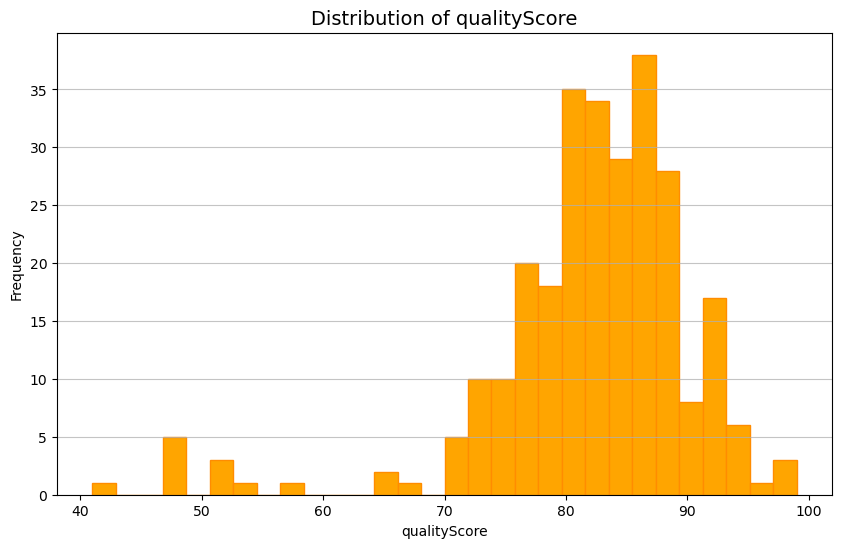

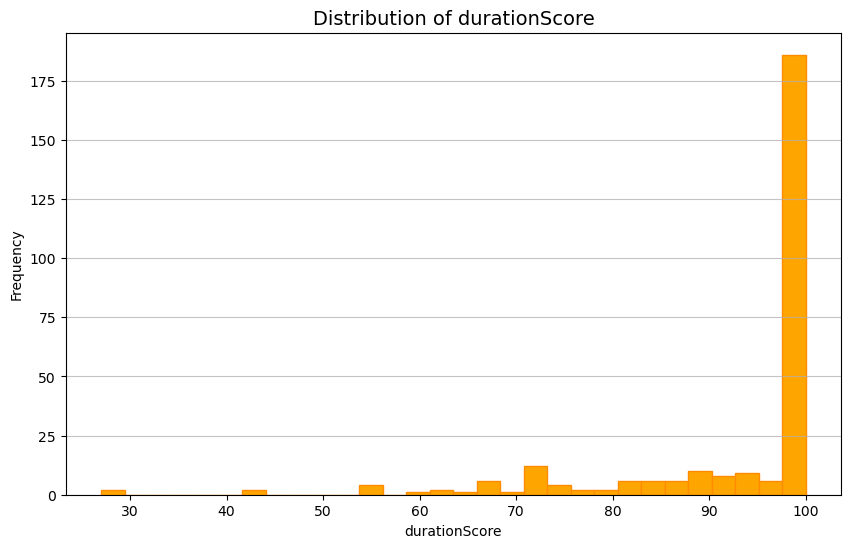

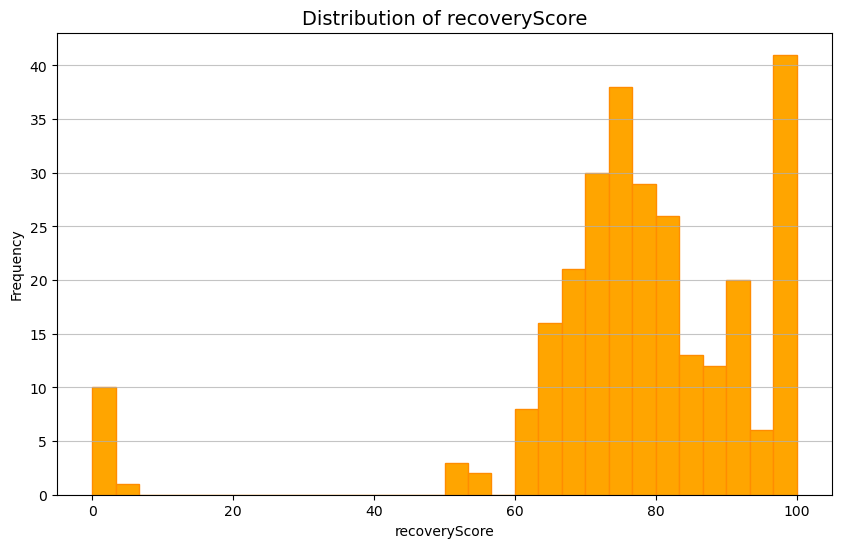

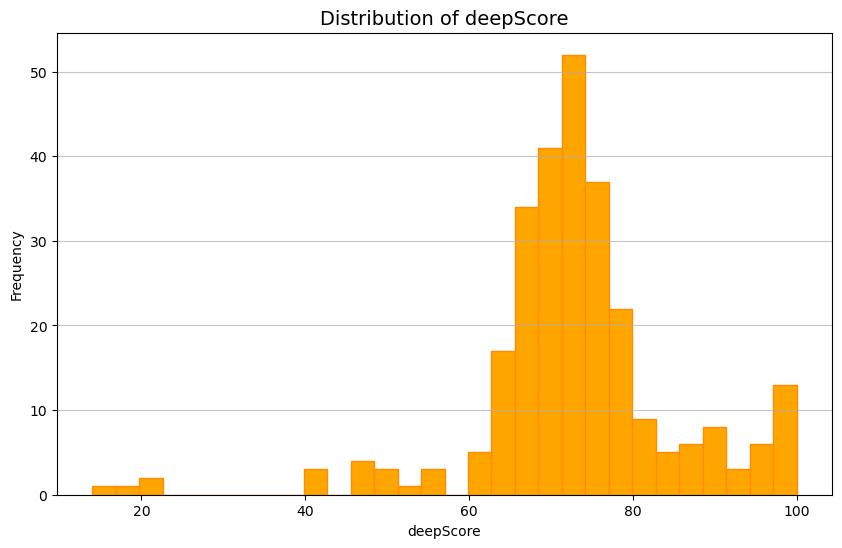

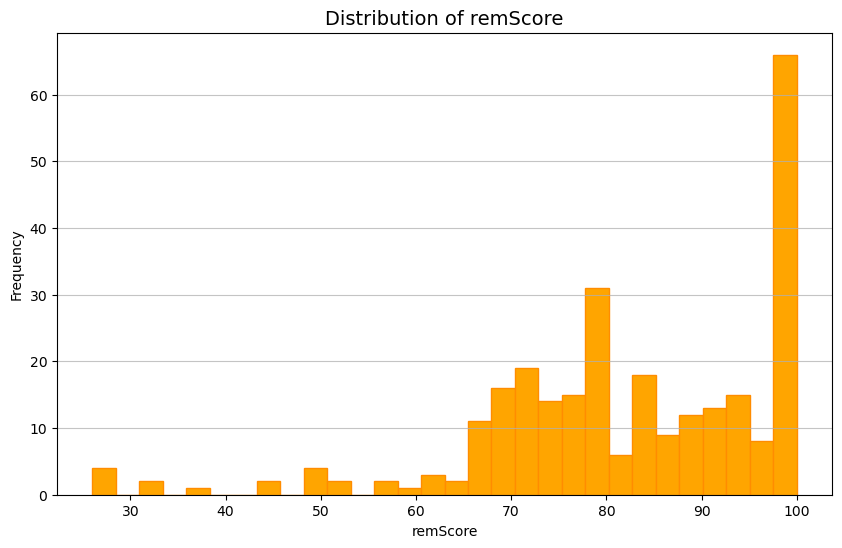

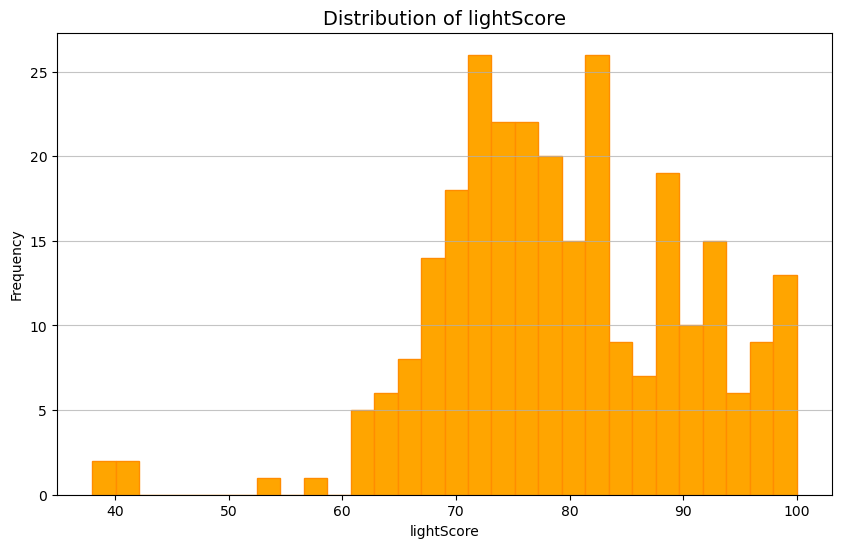

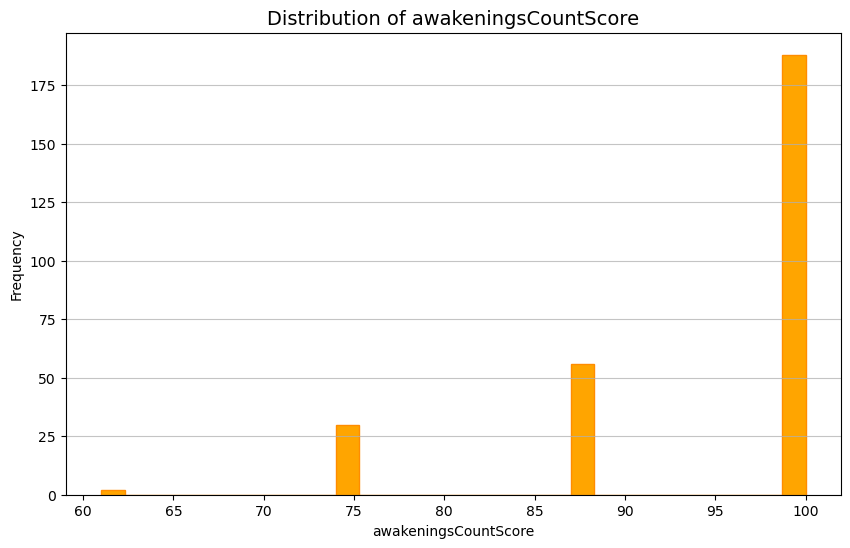

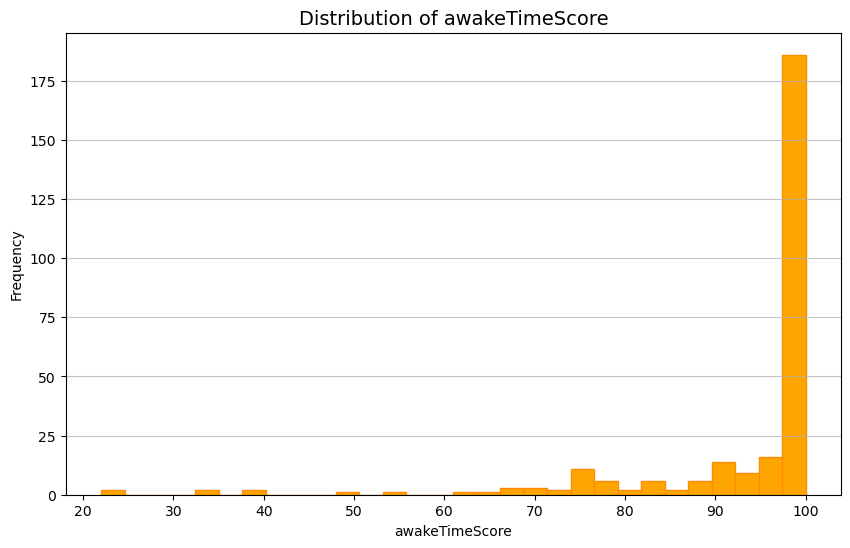

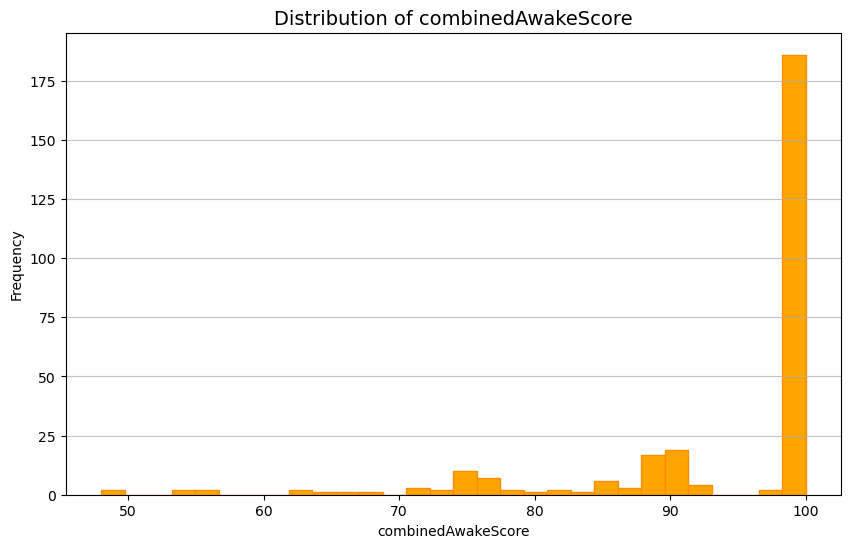

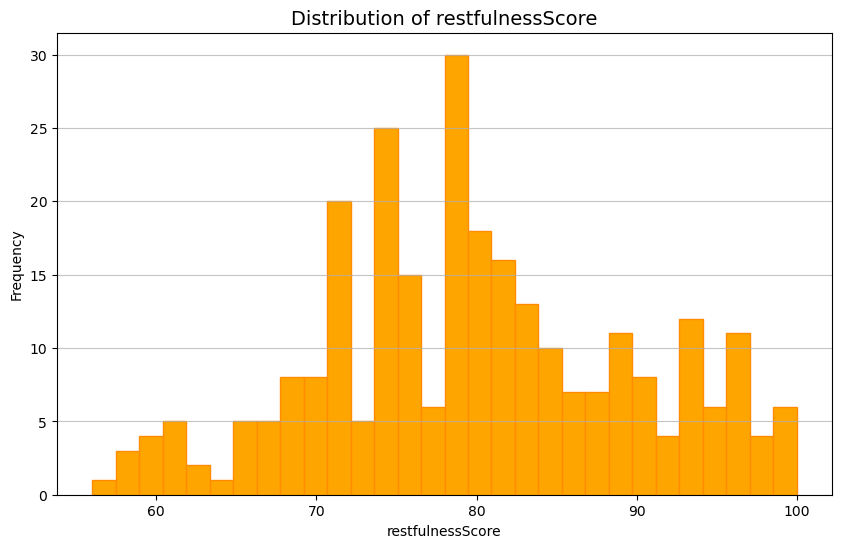

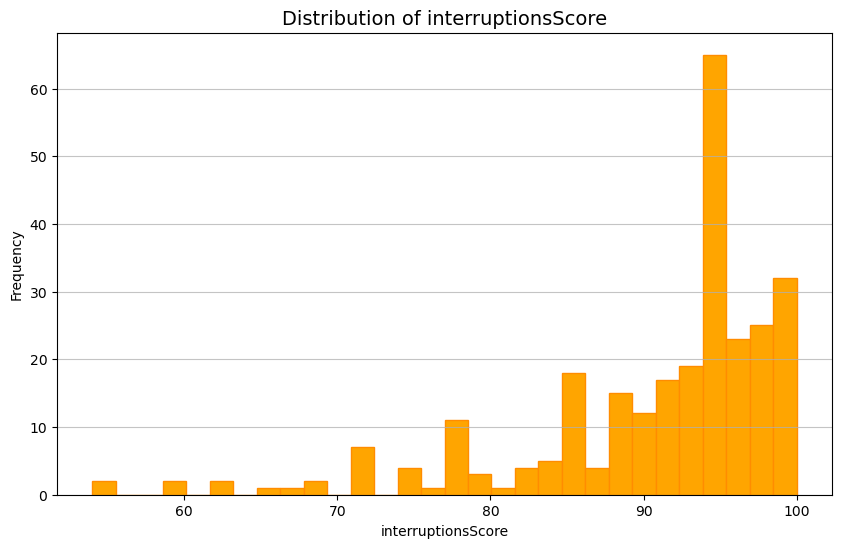

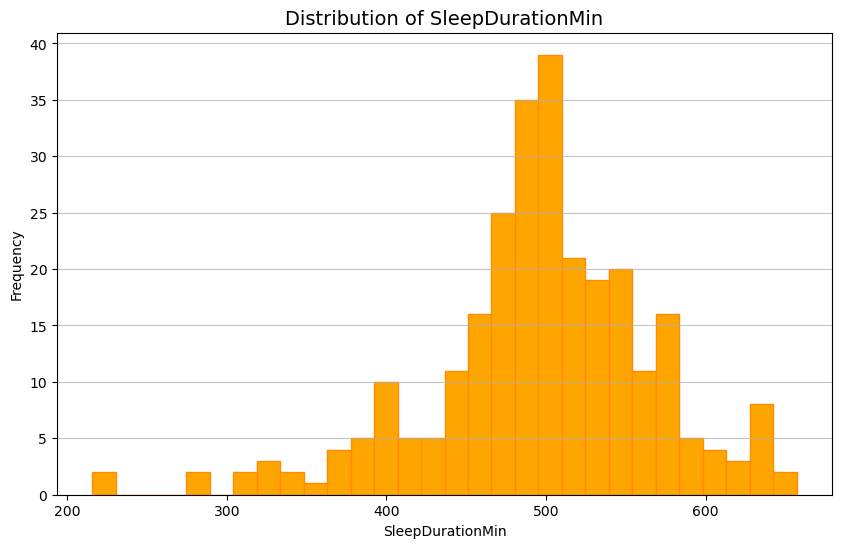

In [4]:
# Create a function that makes distribution plots for all continuous variables

def plot_distribution(data, column_name):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, color='orange', edgecolor='darkorange')
    plt.title(f'Distribution of {column_name}', fontsize=14)
    plt.xlabel(column_name, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

for column in sleep.columns:
    if pd.api.types.is_numeric_dtype(sleep[column]):
        plot_distribution(sleep[column], column)

In [5]:
# Prepare data for a model
print(sleep.BedTime[0]) # create new columns: bedtime hour, bedtime minute, bedtime day same as wakeupdate? (true/false)
print(sleep.WakeTime[0]) # create new columns: waketime hour, waketime minute, wakeup day always True
print(sleep.CalendarDate[0])  # create new columns: wakeup day, wakeup month, wakeup year

2023-12-25 23:00:00
2023-12-26 07:01:00
2023-12-26 00:00:00


In [6]:
# Making new columns - enriching for datetime 
sleep["BedTimeHour"]= sleep.BedTime.dt.hour
sleep["BedTimeMinute"]= sleep.BedTime.dt.minute
sleep["BedTimeBeforeMidnight"]= sleep.BedTime.dt.day!=sleep.CalendarDate.dt.day
sleep["BedTimeDayOfWeek"] =sleep.BedTime.dt.dayofweek

sleep["WakeTimeHour"]= sleep.WakeTime.dt.hour
sleep["WakeTimeMinute"]= sleep.WakeTime.dt.minute

sleep["WakeUpDay"]= sleep.CalendarDate.dt.day
sleep["WakeUpMonth"]=sleep.CalendarDate.dt.month
sleep["WakeUpYear"]=sleep.CalendarDate.dt.year

In [7]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   deepSleepSeconds       276 non-null    int64         
 1   lightSleepSeconds      276 non-null    int64         
 2   remSleepSeconds        276 non-null    float64       
 3   awakeSleepSeconds      276 non-null    int64         
 4   unmeasurableSeconds    276 non-null    int64         
 5   averageRespiration     276 non-null    float64       
 6   lowestRespiration      276 non-null    float64       
 7   highestRespiration     276 non-null    float64       
 8   awakeCount             276 non-null    int64         
 9   avgSleepStress         276 non-null    float64       
 10  restlessMomentCount    276 non-null    int64         
 11  overallScore           276 non-null    int64         
 12  qualityScore           276 non-null    int64         
 13  durat

In [8]:
sleep.iloc[33,23:37]

BedTime                  2024-02-22 21:58:00
WakeTime                 2024-02-23 06:43:00
SleepDuration                0 days 08:45:00
CalendarDate             2024-02-23 00:00:00
SleepDurationMin                       525.0
BedTimeHour                               21
BedTimeMinute                             58
BedTimeBeforeMidnight                   True
BedTimeDayOfWeek                           3
WakeTimeHour                               6
WakeTimeMinute                            43
WakeUpDay                                 23
WakeUpMonth                                2
WakeUpYear                              2024
Name: 33, dtype: object

In [9]:
sleep.drop(["BedTime", "WakeTime", "SleepDuration", "CalendarDate"], axis=1, inplace=True)

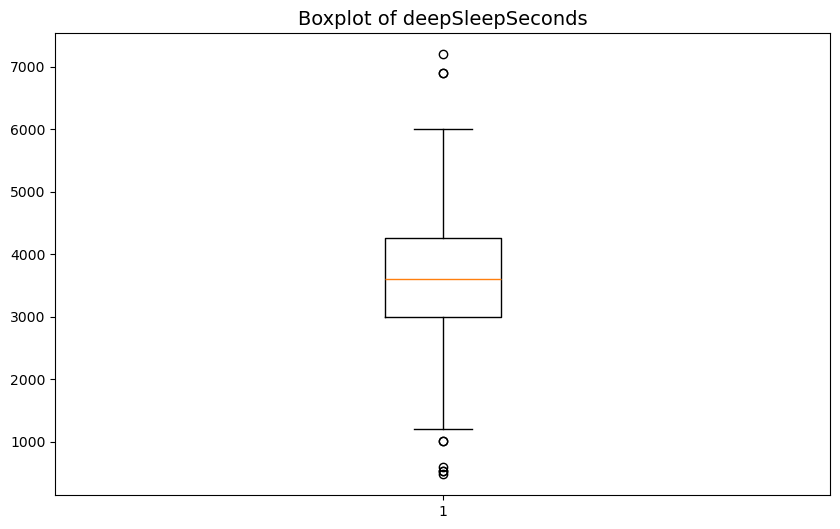

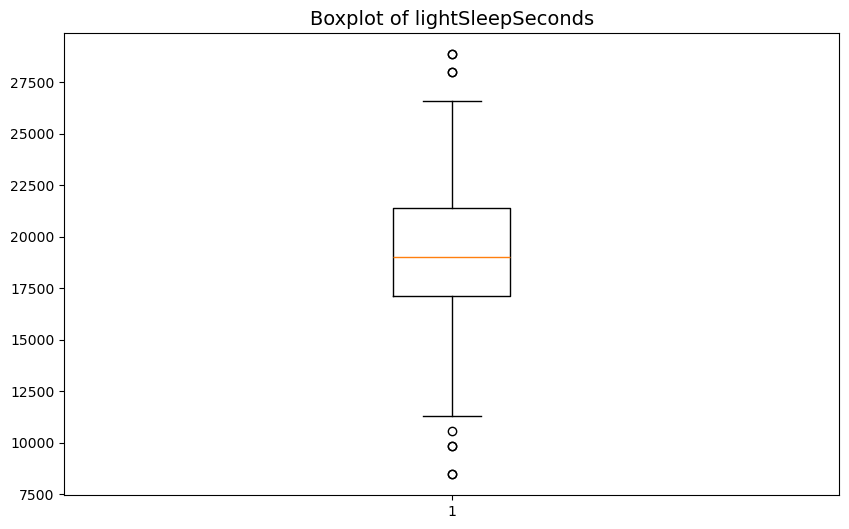

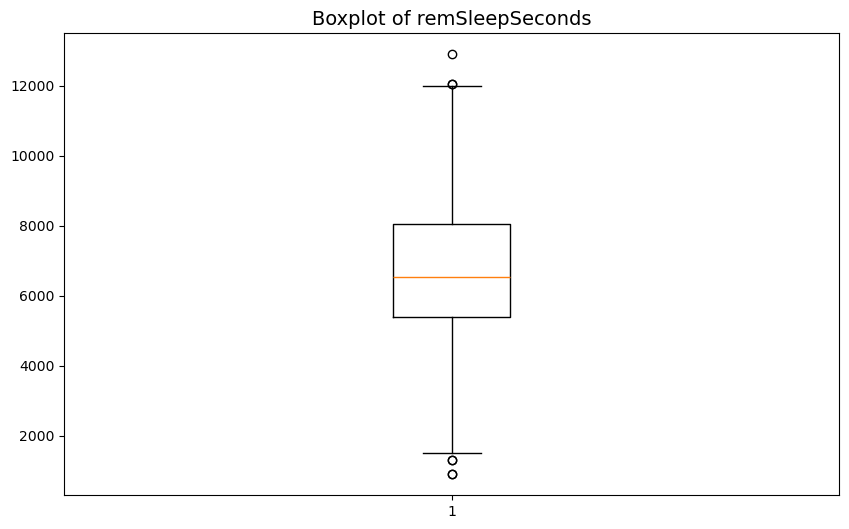

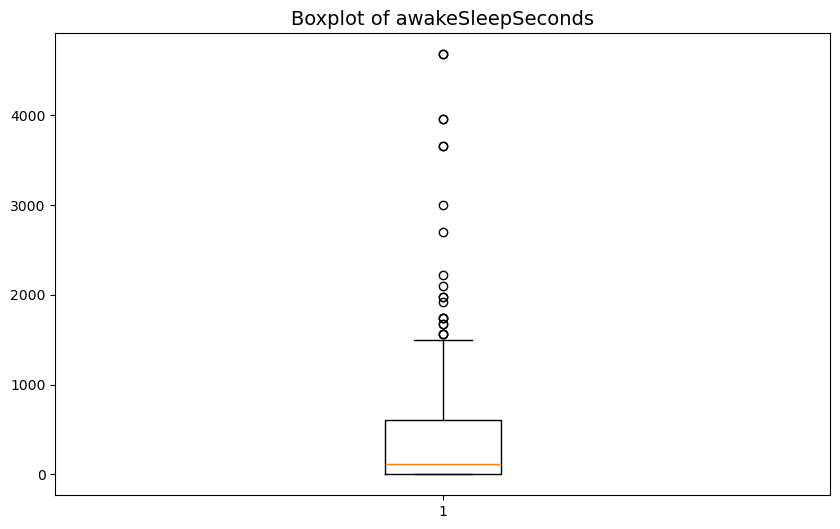

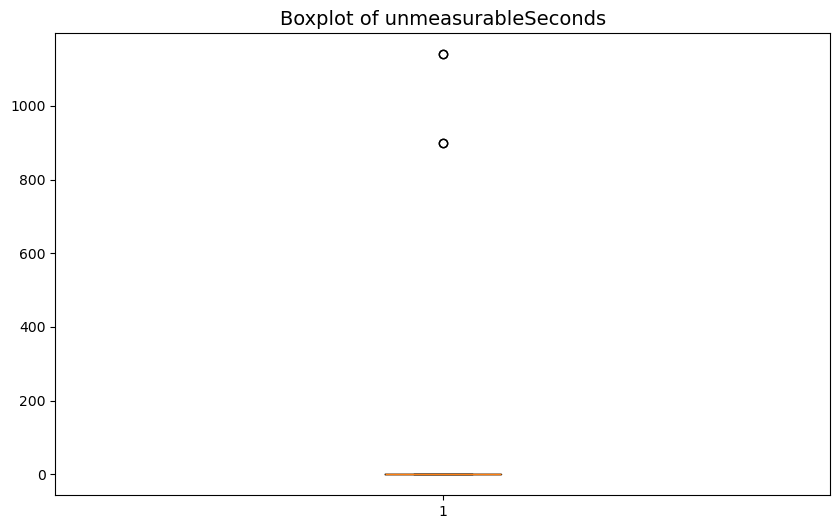

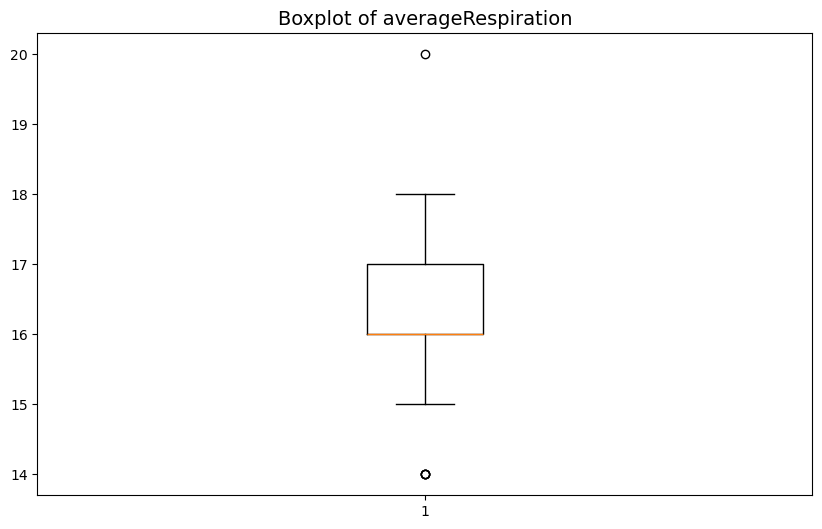

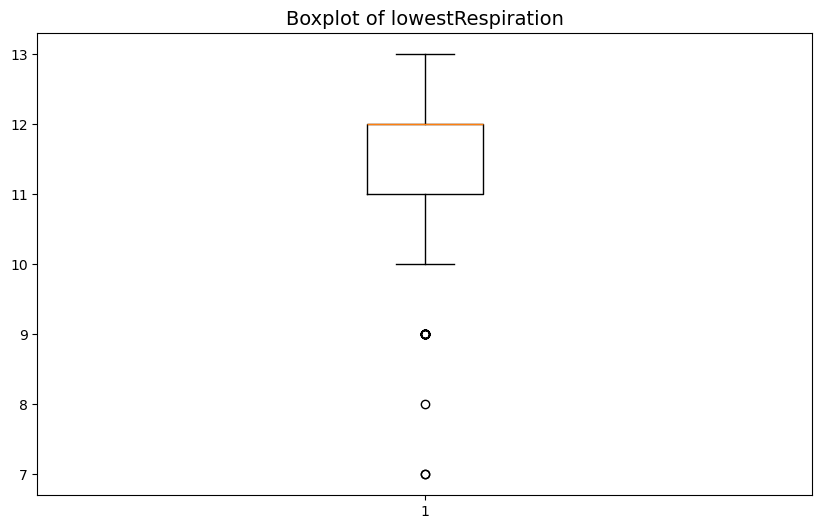

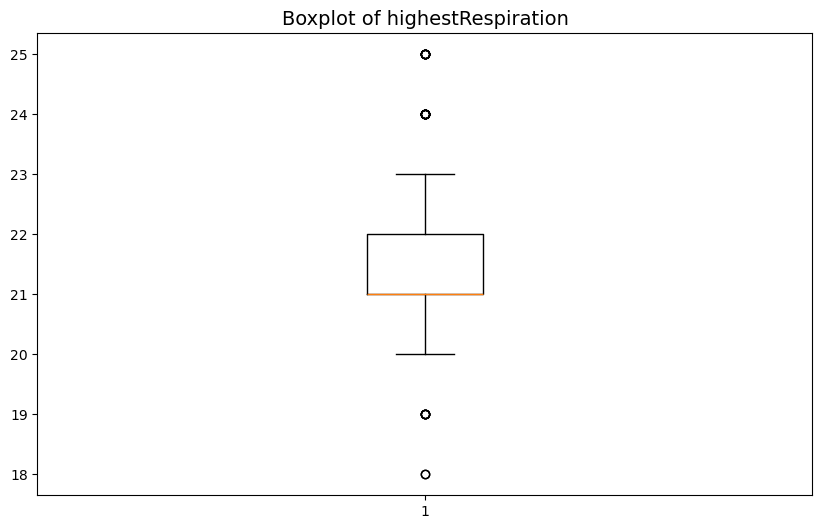

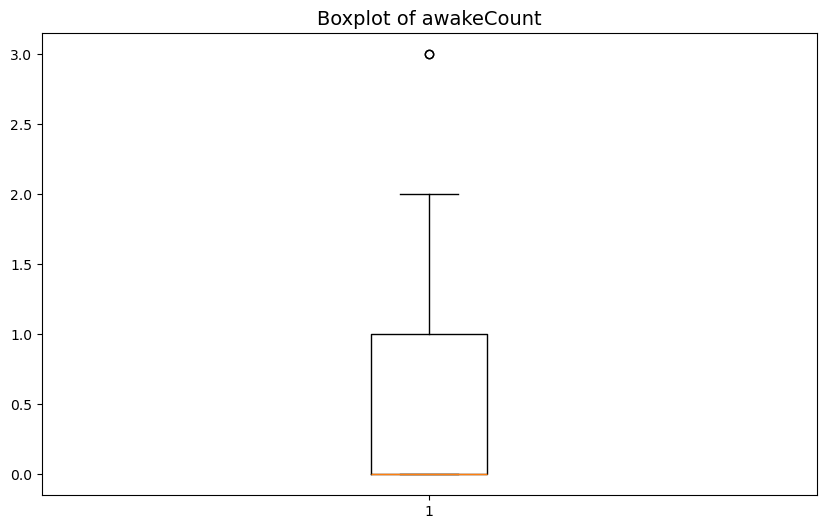

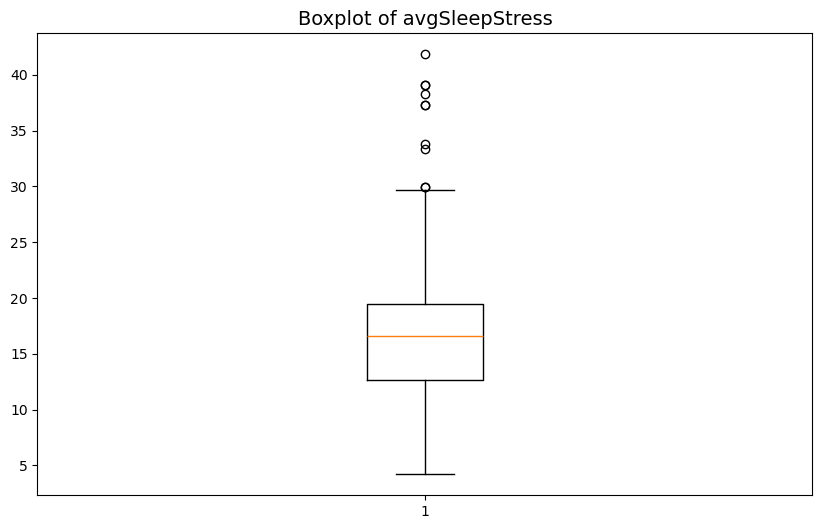

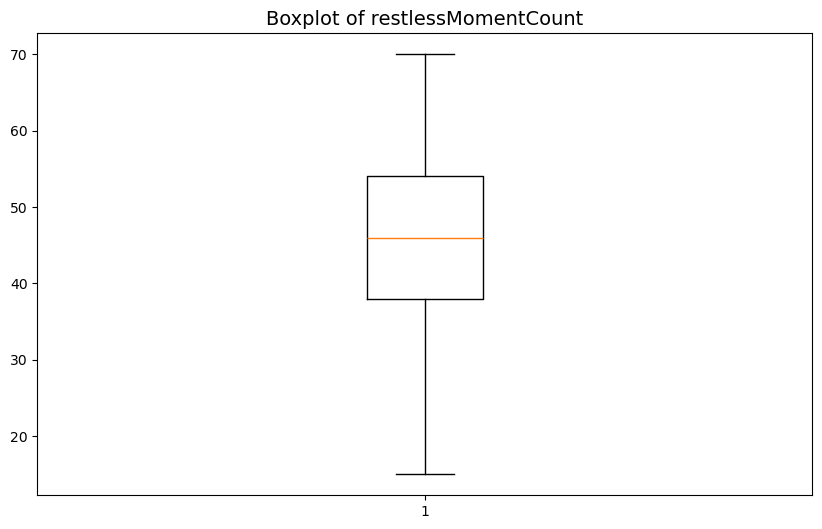

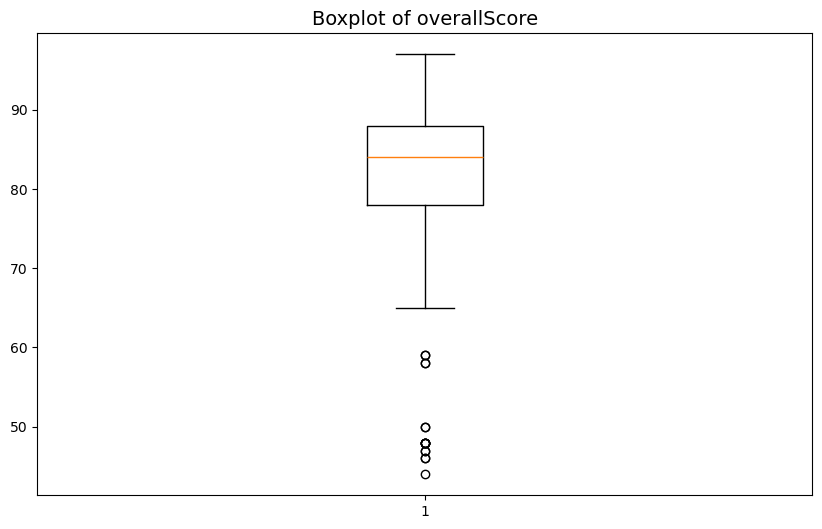

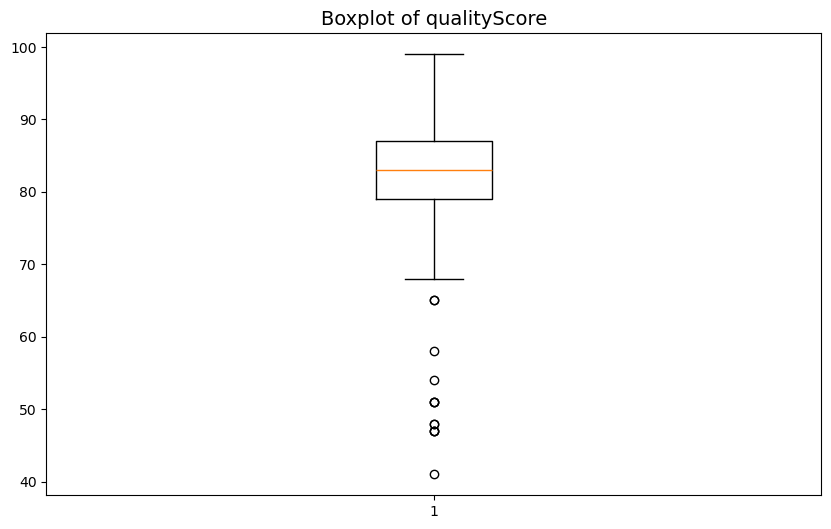

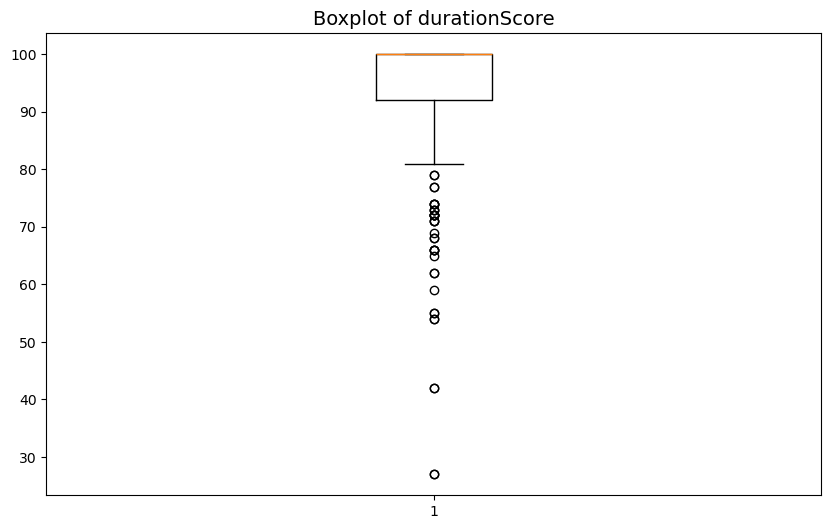

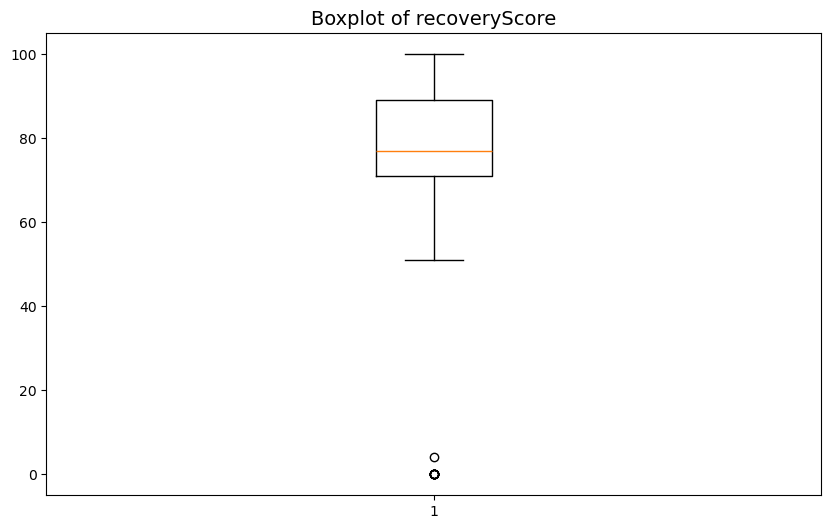

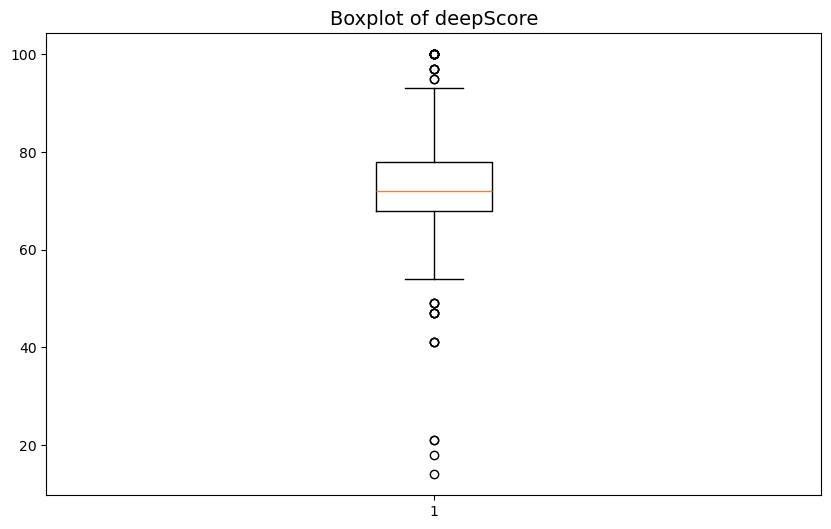

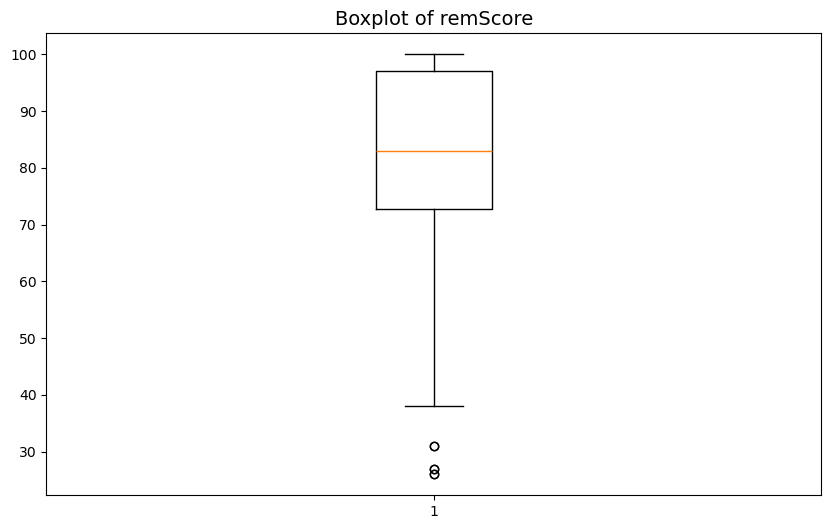

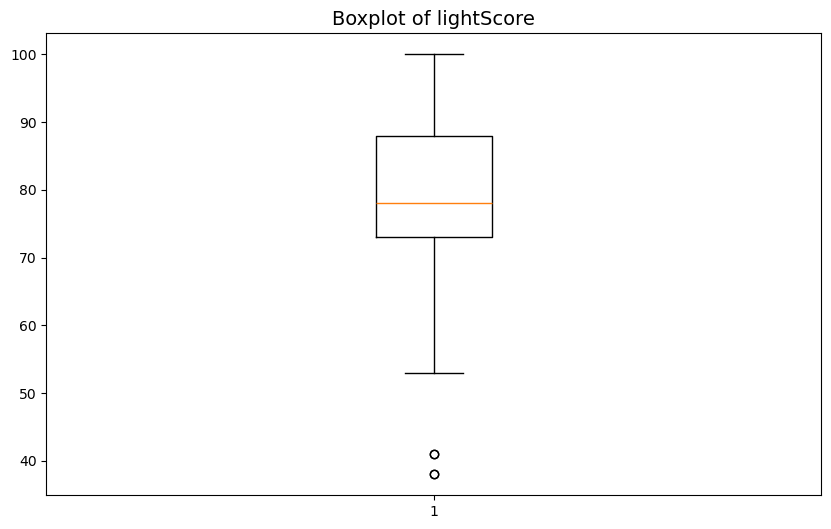

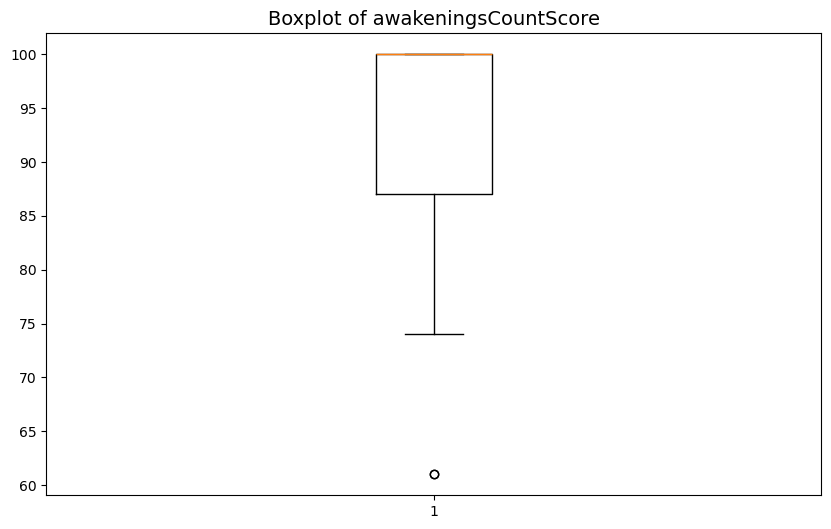

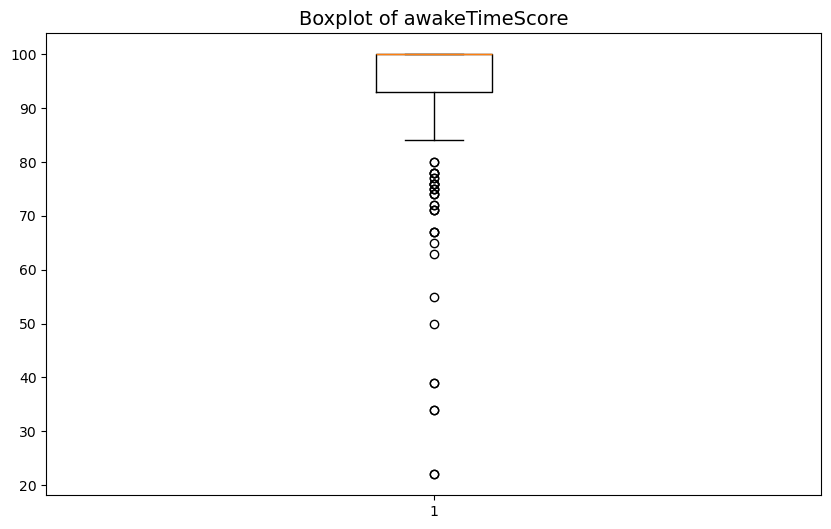

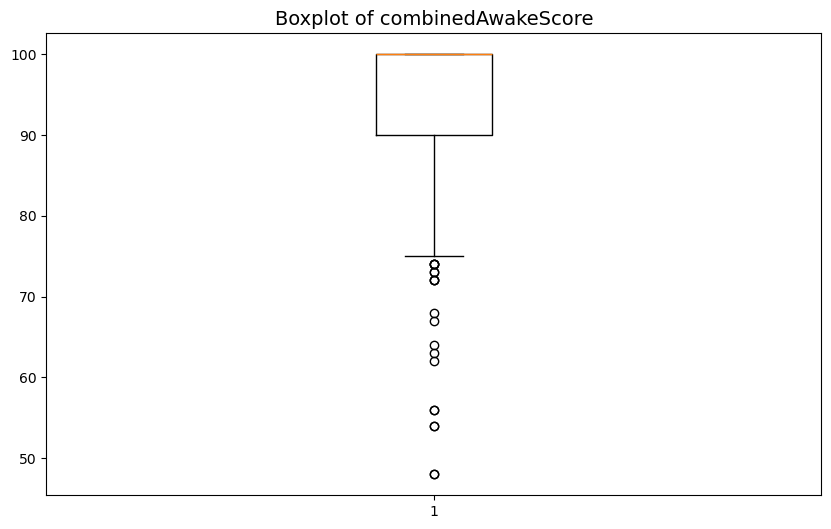

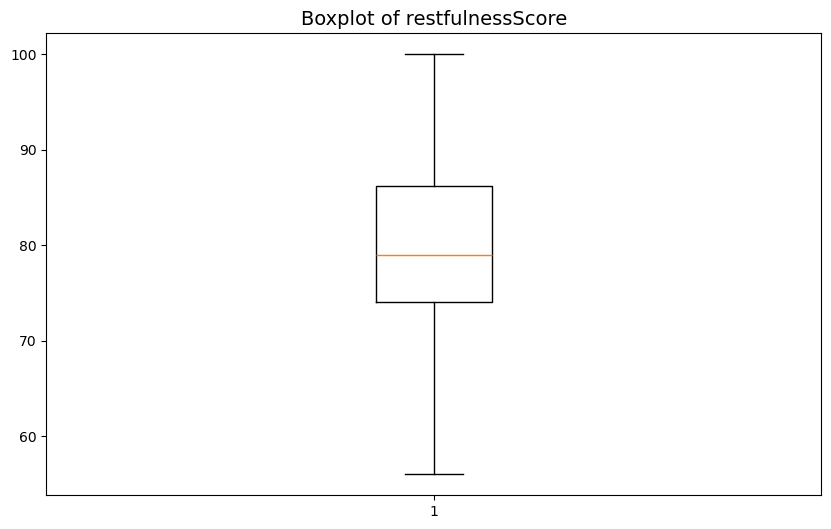

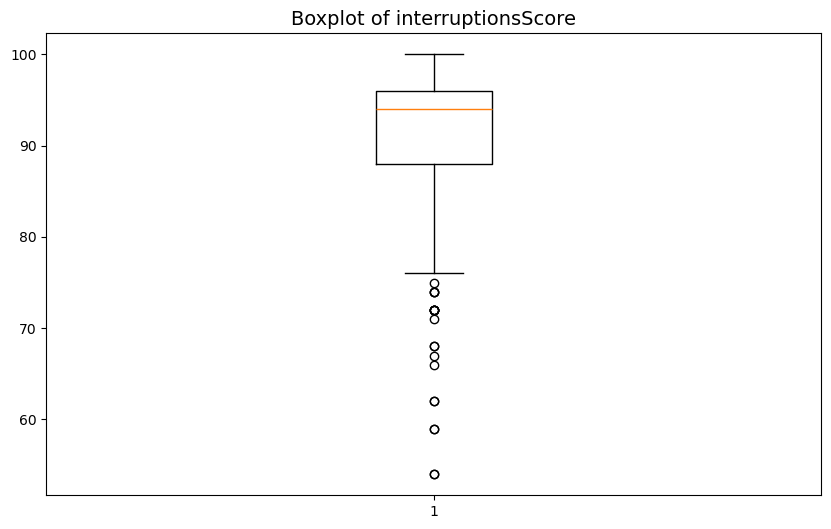

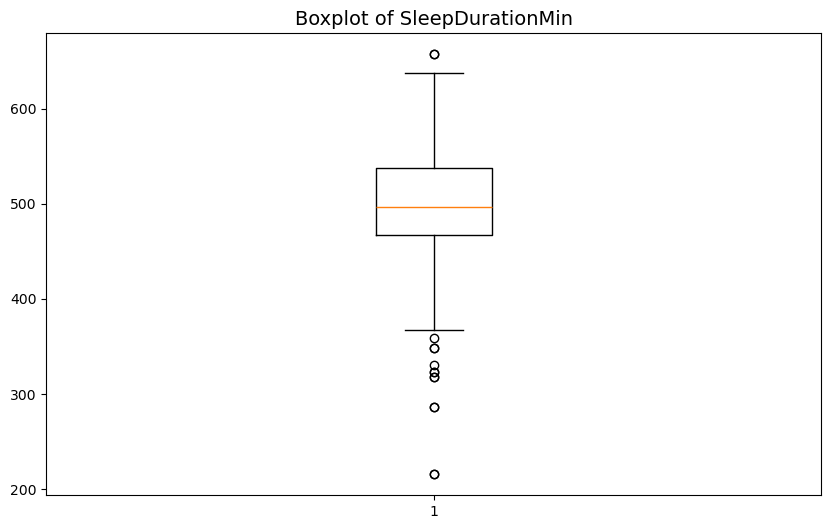

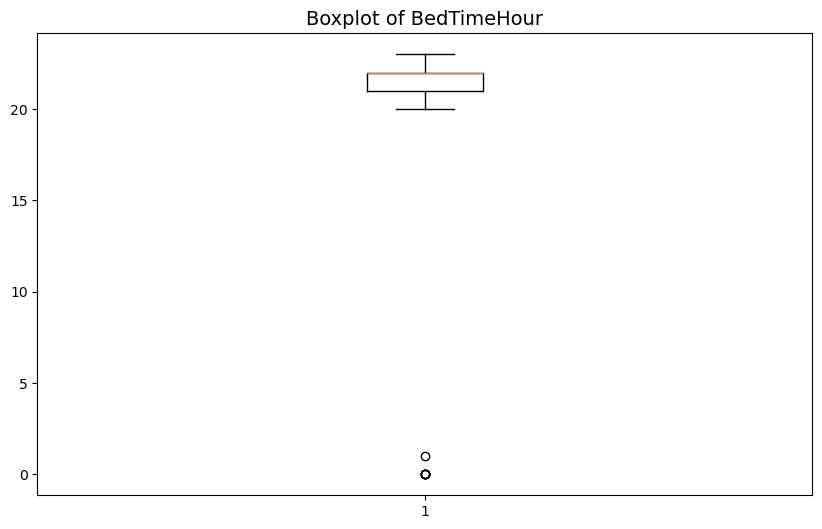

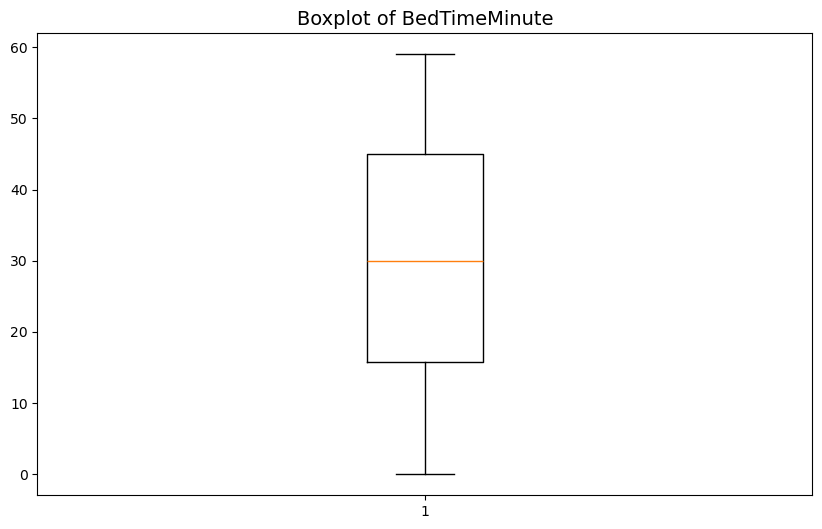

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

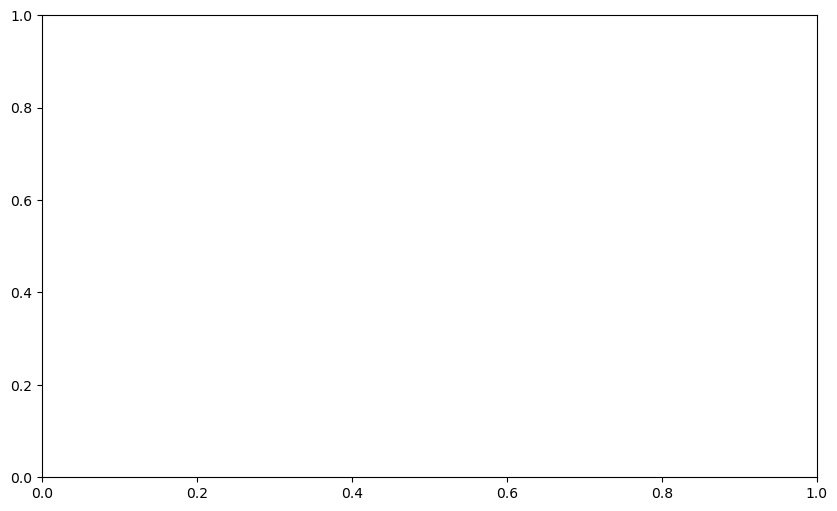

In [10]:
# Normalise or standardize features- sleeping scores are in a scale 1-100, but sleep phases durations are on wider scale

# double check first if there are many outliers
def plot_boxplots(data, column_name):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data)
    plt.title(f'Boxplot of {column_name}', fontsize=14)
    plt.show()

for column in sleep.columns:
    if pd.api.types.is_numeric_dtype(sleep[column]):
        plot_boxplots(sleep[column], column)

In [11]:
#detect outliers using isolationforest method
from sklearn.ensemble import IsolationForest
outliers_dict={}

for column in sleep.columns:
    model = IsolationForest(contamination=0.05, random_state=42) 

    sleep['outlier'] = model.fit_predict(sleep[[column]])

    # Identify outliers (outliers are labeled as -1 by the model)
    outliers = sleep[sleep['outlier'] == -1][column].tolist()
    outliers_dict[column] = outliers

# Print the list of outliers for each column
for column, outliers in outliers_dict.items():
    print(f"Percentage of outliers in {column}: {((len(outliers)*len(column))/100)}")

Percentage of outliers in deepSleepSeconds: 2.08
Percentage of outliers in lightSleepSeconds: 2.38
Percentage of outliers in remSleepSeconds: 2.1
Percentage of outliers in awakeSleepSeconds: 2.21
Percentage of outliers in unmeasurableSeconds: 0.76
Percentage of outliers in averageRespiration: 0.9
Percentage of outliers in lowestRespiration: 0.51
Percentage of outliers in highestRespiration: 1.44
Percentage of outliers in awakeCount: 0.2
Percentage of outliers in avgSleepStress: 1.82
Percentage of outliers in restlessMomentCount: 2.66
Percentage of outliers in overallScore: 1.44
Percentage of outliers in qualityScore: 1.44
Percentage of outliers in durationScore: 1.56
Percentage of outliers in recoveryScore: 0.78
Percentage of outliers in deepScore: 0.99
Percentage of outliers in remScore: 1.12
Percentage of outliers in lightScore: 1.3
Percentage of outliers in awakeningsCountScore: 0.4
Percentage of outliers in awakeTimeScore: 1.82
Percentage of outliers in combinedAwakeScore: 2.52
Per

In [12]:
# Split data first, then standardize each set separately (to avoid data leakage)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into x and y
x=sleep.drop("overallScore", axis=1)
y=sleep["overallScore"]

# split into test train
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

# standardize data
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# double check all went correct
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((220, 33), (56, 33), (220,), (56,))

1. Select and train model - **regression model**
2. Evaluate a model
3. Fine-tune a model
4. Feature importance

___________________________________________________________________________________
5. Analyse and validate model
6. Test and validate model
7. Deploy model


In [17]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculate room mean squared log error between perdictions and true labels"""
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds =model.predict(x_train) 
    scores = {"MAE": mean_absolute_error(y_train, train_preds),
             "RMSLE": rmsle(y_train, train_preds),
             "R^2": r2_score(y_train, train_preds)}
    return scores

In [18]:
# Buiding the RandomForestRegressor model

from sklearn.ensemble import RandomForestRegressor

In [27]:
%%time
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(x_train, y_train)

CPU times: total: 141 ms
Wall time: 239 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [28]:
# evaluation of the initial model
show_scores(model)

{'MAE': 0.47909090909090846,
 'RMSLE': 0.013481800279251622,
 'R^2': 0.9940013630232422}

In [21]:
# Hyperparameters tuning
from sklearn.model_selection import RandomizedSearchCV
# Parameters distribution for RandomizedSearchCV
rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [None, 3,5,10],
           "min_samples_split": np.arange(2,20,2),
           "min_samples_leaf": np.arange(1,20,2),
           "max_features": [0.5,1, "sqrt", "log2"]}
# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_distributions=rf_grid, n_iter=100, cv=5, verbose=True)

# Fit model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [22]:
# Find the best model hyperparametes
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 5}

In [26]:
#comparing initial vs hypertuned model performance
hypertuned_model = RandomForestRegressor(n_estimators= 70, min_samples_split= 4, min_samples_leaf= 1, max_features = 0.5, 
                                          max_depth= 5, random_state=42)
hypertuned_model.fit(x_train, y_train)
show_scores(hypertuned_model)

{'MAE': 1.2021417966008385,
 'RMSLE': 0.022440095288741222,
 'R^2': 0.9765441721985882}

In [29]:
# Feature importance
hypertuned_model.feature_importances_

array([1.47175762e-02, 2.07439630e-02, 1.94086971e-01, 1.56890414e-03,
       0.00000000e+00, 7.54775205e-04, 1.09030108e-03, 2.69983620e-03,
       3.57018407e-04, 1.56562184e-01, 1.32782342e-02, 2.16133231e-01,
       9.67111095e-02, 1.14667401e-01, 2.31250450e-02, 2.73937442e-02,
       1.86971372e-02, 2.66813912e-04, 2.55612693e-03, 2.57378409e-03,
       8.70574356e-04, 5.50013015e-03, 5.99901059e-02, 1.31358360e-03,
       4.28453834e-03, 3.87574888e-05, 1.36015527e-03, 1.18727736e-02,
       4.27344126e-03, 1.28864109e-03, 1.19083653e-03, 3.23070715e-05,
       0.00000000e+00])

In [61]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
                         .sort_values("feature_importances", ascending=False)
                         .reset_index(drop=True))
    # Plot dataframe created
    fig, ax = plt.subplots(figsize=(8,6))
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importances")
    ax.invert_yaxis()

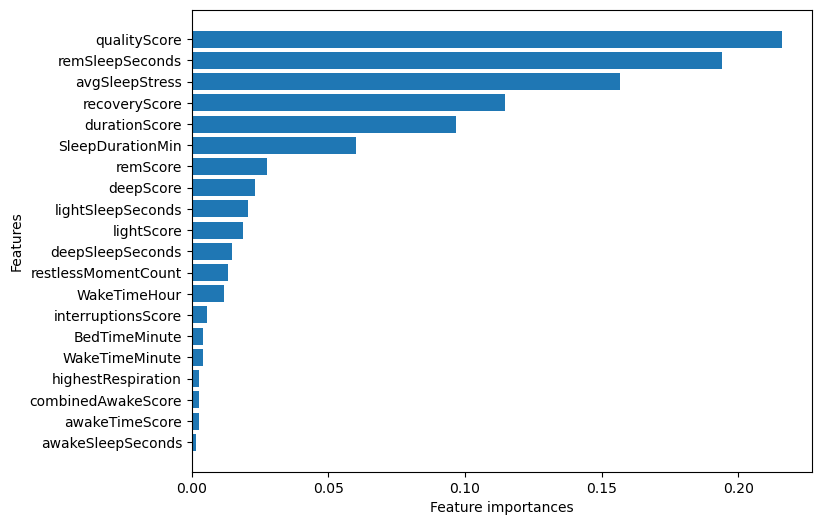

In [62]:
plot_features(x.columns, hypertuned_model.feature_importances_)

In [37]:
# Make predictions on the testdataset

test_preds = hypertuned_model.predict(x_test)
test_preds

array([86.22085971, 84.33468275, 87.7376627 , 46.8475    , 84.97401274,
       69.53160783, 83.50545101, 87.36383157, 90.16550152, 79.79962872,
       83.51957025, 79.67278113, 83.50545101, 87.95491441, 77.56077478,
       68.79626589, 90.62679043, 87.34418498, 83.84861047, 88.75388264,
       87.5024731 , 77.09701507, 88.32548768, 87.91924633, 87.84383885,
       75.59959734, 75.59959734, 86.88257801, 50.25770975, 74.77974143,
       81.56269801, 59.11949858, 83.19608513, 83.51426119, 81.66399364,
       82.20662912, 82.76842003, 74.77974143, 85.56277154, 81.27732906,
       75.96969357, 83.47169736, 87.69889571, 89.06343699, 80.63760931,
       77.08083058, 84.37934187, 81.99777792, 88.1702378 , 78.0939317 ,
       87.46626354, 87.77230354, 82.78177596, 81.36701984, 87.18303383,
       88.34092327])

In [45]:
# Format predictions into table with actual sleep score and bool column if pred was correct
sleep_score_predictions = pd.DataFrame()
sleep_score_predictions["ScorePredictions"]=test_preds
sleep_score_predictions["ActualScore"]=y_test.values
tolerance=5
sleep_score_predictions["CorrectPrediction"]=abs(y_test.values - test_preds) <= tolerance

In [46]:
sleep_score_predictions

,ScorePredictions,ActualScore,CorrectPrediction
0,86.220860,87,True
1,84.334683,81,True
2,87.737663,87,True
3,46.847500,46,True
4,84.974013,85,True
5,69.531608,69,True
6,83.505451,78,False
7,87.363832,88,True
8,90.165502,90,True
9,79.799629,80,True


In [49]:
sleep_score_predictions.CorrectPrediction.value_counts()

CorrectPrediction
True     53
False     3
Name: count, dtype: int64

In [54]:
53/56*100

94.64285714285714